#### Results Section Visualisation:
#### A Bar Chart Showing Short Term Relative Abundance Change (%) For each Species
Four bar charts will be produced in a combined figure. They will illustrate relative abundance change for:

- All habitats
- Hedgerow and field margins
- Road verges
- Damp grassland and meadow

In [1]:
# Importing the required packages
import numpy as np
import pandas as pd
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# 'master_dataset' contains the common names for each butterfly. It will be needed when 
# presenting the results.
master_dataset = pd.read_csv(project_root/'Data'/'UKBMS'/'ukbms_master_v1.csv', index_col=0)

# Importing the required datasets
boot_stats_2 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_2.csv', index_col=0)
boot_stats_4 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_4.csv', index_col=0)
boot_stats_8 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_8.csv', index_col=0)
boot_stats_54 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_54.csv', index_col=0)
boot_stats_75 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_75.csv', index_col=0)
boot_stats_76 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_76.csv', index_col=0)
boot_stats_84 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_84.csv', index_col=0)
boot_stats_88 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_88.csv', index_col=0)
boot_stats_93 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_93.csv', index_col=0)
boot_stats_98 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_98.csv', index_col=0)
boot_stats_99 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_99.csv', index_col=0)
boot_stats_100 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_100.csv', index_col=0)
boot_stats_104 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_104.csv', index_col=0)
boot_stats_106 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_106.csv', index_col=0)
boot_stats_121 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_121.csv', index_col=0)
boot_stats_122 = pd.read_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_122.csv', index_col=0)

#### Acquiring Common Names for each Species from 'master_dataset'
'species_code' is the primary key which will be used for accessing common names.

In [2]:
common_name = (
    master_dataset[['species_code','common_name']]
    .drop_duplicates()
    .reset_index(drop=True)
)

#### Joining all Species 'boot_stats' DataFrames into a Single DataFrame

In [3]:
# A column needs to be created in each 'boot_stats' df that details the species code 
# A unique list of the species codes is created
species_list = [2,4,8,54,75,76,84,88,93,98,99,100,104,106,121,122]

# An empty dataframe is created to store the species codes for all species
species_code_master = pd.DataFrame()

# the species list is looped through, creating 31 rows per species. This is equal to the
# number of unique survey years.
for i in species_list: 
    species_code = pd.DataFrame({'species_code':[i]*31})
    species_code_master = (
        pd.concat([species_code_master, species_code], # rows are added to master df
                  ignore_index=True)
    ) 

In [4]:
# Joining DataFrames
boot_stats = pd.concat([boot_stats_2,
                       boot_stats_4,
                       boot_stats_8,
                       boot_stats_54,
                       boot_stats_75,
                       boot_stats_76,
                       boot_stats_84,
                       boot_stats_88,
                       boot_stats_93,
                       boot_stats_98,
                       boot_stats_99,
                       boot_stats_100,
                       boot_stats_104,
                       boot_stats_106,
                       boot_stats_121,
                       boot_stats_122], ignore_index=True)

See cell below: 

The 'boot_stats' df containing all the bootsrapped relative abundance predictions, is 
joined with the 'species_code_master' df, that contains all the unique species codes. 
The number of rows in both df's is the same.

In [5]:
boot_stats['species_code'] = species_code_master

#### Computing Change in Relative Abundance
- The visual will show 'short term' relative abundance changes.
- 'Short term' is considered to be changes over the past 10 years.

In [6]:
# The 'boot_stats' dataframe is filtered to extract the required years.
rel_abundance = (
    boot_stats[
    (boot_stats['year']==1993) # baseline year for long term changes
    | (boot_stats['year']==2013) # for short term changes
    | (boot_stats['year']==2023) # latest survey year
    ]
    .drop_duplicates(['year', 'species_code']) 
    .drop(columns=['geometric_mean', # removing redundant columns. Only median required. 
                   'upper_b_predict', 
                   'lower_b_predict'])
    .reset_index(drop=True) # rows removed, so index is reset.
)

In [7]:
# common name column is added by joining with species code
rel_abundance = rel_abundance.merge(common_name, 
                                    on='species_code', 
                                    how='left')

In [8]:
abundance_change = rel_abundance.copy()
# computing the short term percentage change in relative abundance
abundance_change['percent_short_term'] = (
    # the data are grouped by species code
    abundance_change.groupby('species_code')['median_predict']
    .transform(lambda x: (x.iloc[2] # 2023 relative abundance
                          - x.iloc[1]) # subtracting 2013 relative abundance
               /x.iloc[1] # dividing by 2013 relative abundance
               *100) # multiplying by 100 to get percentage change
)

#### Cleaning Results DataFrame
Percentage change has been computed. The records for all individual years are removed.

In [9]:
short_term_ra = (
    abundance_change[['species_code',
                      'percent_short_term',
                      'common_name']]
    .drop_duplicates()
)

# sorting values before the colour palette is applied. 
short_term_ra = short_term_ra.sort_values('percent_short_term').reset_index(drop=True)

# Capitalising the first word in each string record
short_term_ra['common_name'] = short_term_ra['common_name'].str.title()

#### Creating a New DataFrame for Each Habitat Group
First a dictionary documenting the favoured habitat of each species is created.

In [10]:
# HF: hedgerow and field margins
# RV: road verge
# GM: damp grassland and meadow

habitats_dict = {121:'HF,RV,GM',
                2:'HF,RV',
                8:'HF,GM',
                99:'HF,RV,GM',
                88:'HF',
                93:'',
                84:'HF,RV',
                4:'HF,RV,GM',
                106:'GM',
                98:'HF',
                104:'',
                75:'HF,RV',
                100:'HF',
                54:'HF,RV',
                76:'HF,RV',
                122:''}

In [ ]:
# Creating new dataframe and adding habitat records for each species
short_term_ra_habitat = short_term_ra.copy() # Old dataframe is copied

# new column created with place holder string
short_term_ra_habitat['habitat'] = 'enter_habitat_type' 

See cell below:

The species code in each row of DataFrame 'short_term_ra_habitat' is used to subset Dictionary 'habitats_dict'. 
The resulting habitat labels are added to the habitat column of the 'short_term_ra_habitat' dataframe for that particular row.

In [ ]:
for index, row in short_term_ra_habitat.iterrows():
    short_term_ra_habitat.loc[index,'habitat'] =  habitats_dict[row['species_code']] 

In [12]:
# A dataframe is created for each habitat by using the habitat records as a filter
# Hedgerow and field margin dataframe
hf = (
    short_term_ra_habitat[
    short_term_ra_habitat['habitat'].str.contains('HF') # Hedgerow and field margins
    ].reset_index(drop=True)
)

# Road Verge habitat dataframe
rv = (
    short_term_ra_habitat[
    short_term_ra_habitat['habitat'].str.contains('RV') # Road verges
    ].reset_index(drop=True)
)

# Grassland and meadow habitat dataframe
gm = (
    short_term_ra_habitat[
    short_term_ra_habitat['habitat'].str.contains('GM') # Damp grassland and meadows
    ].reset_index(drop=True)
)

#### Creating the Visual:
#### Arranging the Layout of the Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as mpatches

plt.ioff() # interactve mode off to prevent figures being shown prematurely.
plt.clf() # clears previous plot

# To show all barplots on the same figure, mosiac is used to position accordingly. 
# 'ax_all' will take the entire left side, with individual habitats stacked on the right. 
mosaic =[
    ['ax_all','ax_hf'],
    ['ax_all','ax_rv'],
    ['ax_all','ax_gm'],
]

fig=plt.figure(constrained_layout=True, figsize=(14,8))
ax_dict = fig.subplot_mosaic(mosaic)

None # prevents figures being displayed

#### Creating a Colour Scale

In [ ]:
# Normalisisng the percentage data between 0 and 1. 
normalise=TwoSlopeNorm(vmin=short_term_ra['percent_short_term'].min(),
                  vcenter=0,
                  vmax=short_term_ra['percent_short_term'].max())

None # prevents figures being displayed

#### Creating the All Habitats Axis

In [ ]:
# Using values range between 0 and 1 from 'normalise', a list of colours is added using
# the'RdYlGn' colour palette. The list matches the number rows in 'short_term_ra' 
# dataframe. 
col_grad_all=[]
for values in short_term_ra['percent_short_term']:
    col_grad_all.append(plt.cm.RdYlGn(normalise(values)))

ax_all = sns.barplot(data=short_term_ra,
           x='percent_short_term',
           y='common_name',
            palette=col_grad_all, # red, yellow, green colour spectrum 
           legend=False,
           edgecolor='black',
           linewidth=0.2,
            ax=ax_dict['ax_all']) # axes is added as subplot to figure

ax_all.set_title('All Habitats')

None # prevents figures being displayed

C:\Users\amman\AppData\Local\Temp\ipykernel_25024\3379949054.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_all = sns.barplot(data=short_term_ra,


#### Creating the Hedgerow and Field Margins Axis

In [26]:
# Using values range between 0 and 1 from 'normalise', a list of colours is added using
# the'RdYlGn' colour palette.
col_grad_hf=[]
for values in hf['percent_short_term']:
    col_grad_hf.append(plt.cm.RdYlGn(normalise(values)))
    
ax_hf = sns.barplot(data=hf,
           x='percent_short_term',
           y='common_name',
            palette=col_grad_hf, # red, yellow, green colour spectrum 
           legend=False,
           edgecolor='black',
           linewidth=0.2,
            ax=ax_dict['ax_hf']) # axes is added as subplot to figure

ax_hf.set_title('Hedgerow and Field Margins')

None # prevents figures being displayed

C:\Users\amman\AppData\Local\Temp\ipykernel_25024\545280732.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_hf = sns.barplot(data=hf,


#### Creating the Road Verge Axis

In [27]:
# Using values range between 0 and 1 from 'normalise', a list of colours is added using
# the'RdYlGn' colour palette.
col_grad_rv=[]
for values in rv['percent_short_term']:
    col_grad_rv.append(plt.cm.RdYlGn(normalise(values)))

ax_rv = sns.barplot(data=rv,
           x='percent_short_term',
           y='common_name',
            palette=col_grad_rv, # red, yellow, green colour spectrum 
           legend=False,
           edgecolor='black',
           linewidth=0.2,
            ax=ax_dict['ax_rv']) # axes is added as subplot to figure

ax_rv.set_title('Road Verges')

None # prevents figures being displayed

C:\Users\amman\AppData\Local\Temp\ipykernel_25024\2742853809.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_rv = sns.barplot(data=rv,


#### Creating the Damp Grassland and Meadow Axis

In [28]:
# Using values range between 0 and 1 from 'normalise', a list of colours is added using
# the'RdYlGn' colour palette.
col_grad_gm=[]
for values in gm['percent_short_term']:
    col_grad_gm.append(plt.cm.RdYlGn(normalise(values)))

ax_gm = sns.barplot(data=gm,
           x='percent_short_term',
           y='common_name',
            palette=col_grad_gm, # red, yellow, green colour spectrum 
           legend=False,
           edgecolor='black',
           linewidth=0.2,
            ax=ax_dict['ax_gm']) # axes is added as subplot to figure

ax_gm.set_title('Damp Grassland and Meadow')

None # prevents figures being displayed

C:\Users\amman\AppData\Local\Temp\ipykernel_25024\686636871.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_gm = sns.barplot(data=gm,


#### Formatting of Bar Labels and Axis

In [29]:
# Adjusting the spacing and formatting of the bar labels in each sub plot
for axes in ax_dict.values(): # loops through each subplot in dictionary
    for container in axes.containers: # loops through axes bar
        axes.bar_label(container, 
                       fmt='%.0f', # format string set to 0 decimal places
                       padding=2) # the spacing

None # prevents figures being displayed

In [30]:
# Adjusting the formatting of all subplots
for axes in ax_dict.values(): # loops through each of the axes
    axes.set_ylabel('Species')
    axes.set_xlabel('Change in Relative Abundance (%)')
    axes.set_xticks(np.arange(-100,142,20)) # min and max 'labeled' x-axis value
    axes.set_xlim(-100,130) # min and max x axis value
    axes.tick_params(length=0) # removing the tick marks
    # Drawing a dotted line at x=0 for emphasis
    axes.axvline(x=0,
             linestyle=(0,(10,6)),
               color='black',
               linewidth=0.5)
    axes.margins(x=0.06, y=0.015) 
    # removing the upper and right borders for clean appearance
    sns.despine(left=False, 
                right=True, 
                top=True, 
                bottom=False)

None # prevents figures being displayed

#### Distinguishing 'Non-Significant' Species in the All Habitats Plot
Bars for non-significant species will be filled grey. To specify the correct bars in 
each plot, the index values corresponding to non-significant species are extracted 
from the 'short_term_ra' dataframe. These can be used to identify the correct bars
in the plot.

This process is repeated for the remaining habitats. 

In [31]:
# Species codes for species whoose short term changes were not significant
not_significant_all = [4, 84, 98, 104, 106] 

# All habitats
not_significant_index_all = []
for index, row in short_term_ra[['species_code']].iterrows():
    if row['species_code'] in not_significant_all:
        not_significant_index_all.append(index)

# Using non-significant species index values from each habitat dataframe, to identify 
# and fill the corresponding bars in each subplot grey. 
bars_all = ax_all.patches
for index, bar in enumerate(bars_all):
    if index in not_significant_index_all:
        bar.set_facecolor('gray')

# This process is repeated for the remianing habitats

#### Distinguishing 'Non-Significant' Species in the Hedgerow and Field Margins Plot
the index values corresponding to non-significant species are extracted 
from the 'hf' dataframe.

In [32]:
# extracting non-significant index values from hedgerow and field margin dataframe
not_significant_index_hf = []
for index, row in hf.iterrows():
    if row['species_code'] in not_significant_all:
        not_significant_index_hf.append(index)

# Filling bars with corresponding index values grey
bars_hf = ax_hf.patches
for index, bar in enumerate(bars_hf):
    if index in not_significant_index_hf:
        bar.set_facecolor('gray')

#### Distinguishing 'Non-Significant' Species in the Road Verge Plot
the index values corresponding to non-significant species are extracted 
from the 'rv' dataframe.

In [33]:
# extracting non-significant index values from road verge dataframe
not_significant_index_rv = []
for index, row in rv.iterrows():
    if row['species_code'] in not_significant_all:
        not_significant_index_rv.append(index)

# Filling bars with corresponding index values grey
bars_rv = ax_rv.patches
for index, bar in enumerate(bars_rv):
    if index in not_significant_index_rv:
        bar.set_facecolor('gray')

#### Distinguishing 'Non-Significant' Species in the Damp Grassland and Meadows Plot
the index values corresponding to non-significant species are extracted 
from the 'gm' dataframe.

In [34]:
# extracting non-significant index values from grassland and meadow dataframe
not_significant_index_gm = []
for index, row in gm.iterrows():
    if row['species_code'] in not_significant_all:
        not_significant_index_gm.append(index)

# Filling bars with corresponding index values grey
bars_gm = ax_gm.patches
for index, bar in enumerate(bars_gm):
    if index in not_significant_index_gm:
        bar.set_facecolor('gray')

#### Creating a Custom Legend with 'Non-significant' Colour Included

In [35]:
grey_patch = mpatches.Patch(color='gray', label='Not Significant')
red_patch = mpatches.Patch(color='darkred', label='Decline')
green_patch = mpatches.Patch(color='green', label='Increase')

# The legend fits well when added to the 'ax_all' plot. 
ax_all.legend(handles=[red_patch, grey_patch, green_patch])

None

<Figure size 640x480 with 0 Axes>

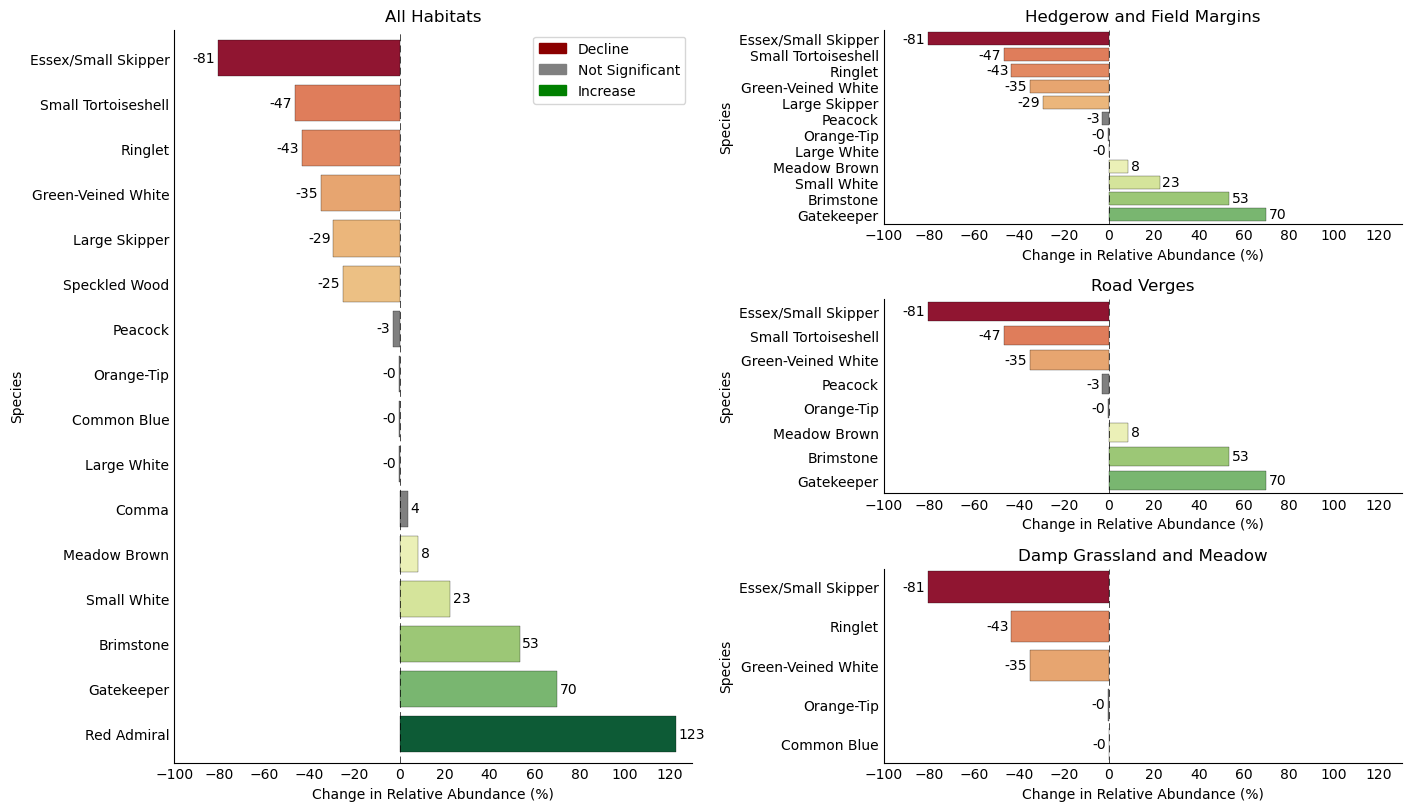

In [36]:
plt.savefig(project_root/'project_pics'/'short_term.png', dpi=300, bbox_inches='tight')
plt.show()